# Identificación de autoría de código fuente uniautoral con Machine Learning

En este trabajo se emplearán diversas técnicas conocidas de machine learning ("aprendizaje automático") al servicio de la identificación de autoría de código fuente. El dataset es extraído de Google Code Jam entre los años 2008 y 2020 (https://github.com/Jur1cek/gcj-dataset).

**Disclaimer: este código lo hice medio a las apuradas y soy un queso con Python, no me hagan bullying.**

Primero se importan los módulos relevantes:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import dill
from pygments.lexers import CppLexer
from pygments.lexers import PythonLexer
from pygments.token import Token
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier # k Nearest Neighbors
from sklearn.svm import SVC # Support Vector Machine
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Multinomial
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

El módulo **dill** podría ser útil para guardar y cargar el entorno, ahorrando el trabajo de ejecutar todos los clasificadores para obtener sus resultados cada vez que se reinicia la notebook. De todos modos, no lo usé xd.

Se extrae el dataset, que está separado en años (para lo cual es necesario tener los datasets gcj2008.csv a gcj2017.csv de https://github.com/Jur1cek/gcj-dataset en un subdirectorio 'datasets' dentro del directorio donde está la notebook):

In [2]:
first_year = 8
last_year = 17

csv_files = ("./datasets/gcj20" + ("0" if first_year + i < 10 else "" ) + str(first_year + i) + ".csv" for i in range(last_year - first_year + 1))

df_list = (pd.read_csv(file) for file in csv_files)

df = pd.concat(df_list, ignore_index=True)
df

,Unnamed: 0,year,round,username,task,solution,file,full_path,flines
0,0,2008,32002,MikeSeibert,24445,0,EndlessKnight.java,gcj/2008/32002/MikeSeibert/24445/0/extracted/E...,import java.util.Scanner;\n \n public class En...
1,1,2008,32002,MikeSeibert,24444,1,Pockets.java,gcj/2008/32002/MikeSeibert/24444/1/extracted/P...,import java.util.Scanner;\n \n public class Po...
2,2,2008,32002,MikeSeibert,24444,0,Pockets.java,gcj/2008/32002/MikeSeibert/24444/0/extracted/P...,import java.util.Scanner;\n \n public class Po...
3,3,2008,32002,MikeSeibert,24446,0,NoCheating.java,gcj/2008/32002/MikeSeibert/24446/0/extracted/N...,import java.util.Scanner;\n \n public class No...
4,4,2008,32002,bhamrick,24445,0,D.cpp,gcj/2008/32002/bhamrick/24445/0/extracted/D.cpp,#include<cstdio>\n #include<cstdlib>\n \n #def...
...,...,...,...,...,...,...,...,...,...
1248501,185590,2017,3274486,LSC,5706636844859392,1,B.py,gcj/2017/3274486/LSC/5706636844859392/1/extrac...,T = int(raw_input())\n for t in xrange(T):\n ...
1248502,185591,2017,3274486,LSC,5706636844859392,0,B-small.py,gcj/2017/3274486/LSC/5706636844859392/0/extrac...,"def solve():\n n1, n2 = map(int, raw_input..."
1248503,185592,2017,3274486,LSC,5768968631484416,1,A.py,gcj/2017/3274486/LSC/5768968631484416/1/extrac...,import math\n PI = math.acos(-1.0)\n \n T = in...
1248504,185593,2017,3274486,LSC,5768968631484416,0,A.py,gcj/2017/3274486/LSC/5768968631484416/0/extrac...,import math\n PI = math.acos(-1.0)\n \n T = in...


Se preprocesa un poco el dataframe:

In [3]:
# Borro filas con NaNs (generalmente causados por nombres no utf-8, 
# como aquellos con caracteres chinos o japoneses):
df = df.dropna()
df

,Unnamed: 0,year,round,username,task,solution,file,full_path,flines
0,0,2008,32002,MikeSeibert,24445,0,EndlessKnight.java,gcj/2008/32002/MikeSeibert/24445/0/extracted/E...,import java.util.Scanner;\n \n public class En...
1,1,2008,32002,MikeSeibert,24444,1,Pockets.java,gcj/2008/32002/MikeSeibert/24444/1/extracted/P...,import java.util.Scanner;\n \n public class Po...
2,2,2008,32002,MikeSeibert,24444,0,Pockets.java,gcj/2008/32002/MikeSeibert/24444/0/extracted/P...,import java.util.Scanner;\n \n public class Po...
3,3,2008,32002,MikeSeibert,24446,0,NoCheating.java,gcj/2008/32002/MikeSeibert/24446/0/extracted/N...,import java.util.Scanner;\n \n public class No...
4,4,2008,32002,bhamrick,24445,0,D.cpp,gcj/2008/32002/bhamrick/24445/0/extracted/D.cpp,#include<cstdio>\n #include<cstdlib>\n \n #def...
...,...,...,...,...,...,...,...,...,...
1248501,185590,2017,3274486,LSC,5706636844859392,1,B.py,gcj/2017/3274486/LSC/5706636844859392/1/extrac...,T = int(raw_input())\n for t in xrange(T):\n ...
1248502,185591,2017,3274486,LSC,5706636844859392,0,B-small.py,gcj/2017/3274486/LSC/5706636844859392/0/extrac...,"def solve():\n n1, n2 = map(int, raw_input..."
1248503,185592,2017,3274486,LSC,5768968631484416,1,A.py,gcj/2017/3274486/LSC/5768968631484416/1/extrac...,import math\n PI = math.acos(-1.0)\n \n T = in...
1248504,185593,2017,3274486,LSC,5768968631484416,0,A.py,gcj/2017/3274486/LSC/5768968631484416/0/extrac...,import math\n PI = math.acos(-1.0)\n \n T = in...


## Trabajando con los códigos C++

Se decidió evaluar primero la performance de los métodos de clasificación considerando sólo los códigos fuente escritos en el lenguaje **C++**. A continuación se filtran los códigos correspondientes a todos los otros lenguajes en el dataframe:

In [4]:
# Primero dejo en otro data frame las filas del data frame original 
# cuyos valores en la columna "file" terminan con "cpp" o "CPP":

df_cpp = df.copy(deep=True) # Copia profunda de df a df_cpp

# Dejo los últimos tres caracteres en la columna "file":
df_cpp["file"] = df_cpp["file"].str[-3:]

df_cpp = df_cpp[ df_cpp["file"] == "cpp"]

df_cpp["username"].value_counts()

bmerry        307
vepifanov     279
dzhulgakov    272
Eryx          268
Vasyl         261
             ... 
HimJ            1
liyuanhang      1
Kuuhaku         1
balimaco00      1
Kruemel         1
Name: username, Length: 45359, dtype: int64

Puede observarse que hay varios usuarios con al menos 100 códigos fuente en C++, lo cual es una cantidad razonable con la que operar. Se dejan los usuarios en el **top 100** con más contribuciones/códigos (con el top 5 se obtienen valores demasiado altos aún con modelos simples trabajando con pocas features, no presenta mayores dificultades):

In [5]:
# Se determinan los user_count usuarios con más contribuciones (cpp_top):
user_count = 100
usernames = df_cpp["username"].value_counts()
usernames.keys()[0:user_count]
cpp_top = [name for name in usernames.keys()[0:user_count]]

# Se extrae del dataset los user_count usuarios con más contribuciones
# y se los deja en cpp_top:
df_cpp_top = df_cpp.copy(deep=True)
# Se deja en el dataframe las filas correspondientes a usuarios en el top:
df_cpp_top = df_cpp_top[ df_cpp_top["username"].isin(cpp_top) ]
# Se borran las columnas innecesarias del dataframe:
df_cpp_top = df_cpp_top[["username","flines"]]
df_cpp_top

,username,flines
347,vlad89,#include <iostream>\n #include <cstdio>\n #inc...
348,vlad89,#include <iostream>\n #include <cstdio>\n #inc...
349,vlad89,#include <iostream>\n #include <cstdio>\n #inc...
350,vlad89,#include <iostream>\n #include <cstdio>\n #inc...
351,vlad89,#include <iostream>\n #include <cstdio>\n #inc...
...,...,...
1247923,Murphy,#include <cstdio>\n #include <cstdlib>\n #incl...
1247924,Murphy,#include <cstdio>\n #include <cstdlib>\n #incl...
1247925,Murphy,#include <cstdio>\n #include <cstdlib>\n #incl...
1247926,Murphy,#include <cstdio>\n #include <cstdlib>\n #incl...


In [6]:
df_cpp_top["username"].value_counts()#normalize=True)
#df_cpp_top["username"].value_counts().min()

bmerry        307
vepifanov     279
dzhulgakov    272
Eryx          268
Vasyl         261
             ... 
DCLXVI        151
vexorian      151
voover        150
maksay        150
ltaravilse    150
Name: username, Length: 100, dtype: int64

Las clases (*usernames*) están un poco desbalanceadas. Para resolver este problema se define una función para hacer *downsampling*:

In [7]:
def downsample(df, order_col, class_col, head_count):
    # Se ordena el df sobre la columna "order_col" de menor a mayor, 
    # se separa en grupos correspondientes a las clases distinguibles 
    # en la columna "class_col" (que quedaran ordenadas según 
    # "criteria") y se dejan head_count elementos al principio de 
    # cada grupo, devolviéndose la fusión de dichos grupos:
    return df.sort_values(order_col).groupby(class_col).head(head_count)

# Ej.: Se downsamplean elementos en las clases a la clase con menos 
# muestras/ejemplares:
# min_c = df["username"].value_counts().min()
# df_downsampled = downsample(df, "flines", "username", min_c)

Se hace *downsampling* a la cantidad de contribuciones del usuario al fondo del top 100 en el dataframe. Se descartan los códigos de menor longitud (de modo que queden aquellos con, a priori, "más información"): 

In [8]:
min_c = df_cpp_top["username"].value_counts().min()
df_cpp_top_d = downsample(df_cpp_top, "flines", "username", min_c)
df_cpp_top_d["username"].value_counts(normalize=True)

liymouse        0.01
Ra16bit         0.01
fagu            0.01
pieguy          0.01
chEEtah         0.01
                ... 
impetus         0.01
Astein          0.01
Anton.Lunyov    0.01
Ostap           0.01
peter50216      0.01
Name: username, Length: 100, dtype: float64

Notar que, tras el *downsampling*, las muestras quedan balanceadas. En el dataframe quedan 150 muestras por usuario, lo cual significa una reducción considerable de datos para algunos de los usuarios con más contribuciones. Sin embargo, a pesar de la pérdida de datos, se verá a continuación que los modelos son razonablemente buenos.

Antes de vectorizar y aplicar los clasificadores, quizás convenga primero *tokenizar* el código. La *tokenización* consiste en renombrar palabras categorizables bajo algún tipo particular (por ejeplo, 'var1', 'var2' y 'var3' son variables, '1', '3.14159f' y 'hola mundo!' son constantes, '// Hola' y '/* Mundo! \*/' son comentarios, etc.) con un nombre común (como 'id' para las variables, 'cnst' para las constantes y 'cmnt' para los comentarios). Con esta estrategia se pierde un poco de detalle en los códigos, pero se permite observar más fácilmente ciertos otros patrones cuando eventualmente sean vectorizados. Para tokenizar se usarán los *lexers* provistos por **Pygments** (https://pygments.org/).

In [9]:
# Se define una función para tokenizar que recibe una lista 'codes' 
# de strings con los códigos a tokenizar y un lexer:
def tokenize(codes, lang):
    if lang == "cpp" or lang == "c++":
        lexer = CppLexer()
    elif lang == "python" or lang == "py":
        lexer = PythonLexer()
    else:
        print("lang debe ser 'cpp' o 'c++' (para C++) o 'python' o 'py' (para Python).")
    
    # Se genera una lista con listas de tokens por cada código fuente:
    token_lists = [ [token for token in lexer.get_tokens(code)] for code in codes ]
    
    # Acá se manipulan los tokens un poco como se explicó previamente:
    for token_list in token_lists:
        for idx, token in enumerate(token_list):
            # Los tokens son tuplas (type, value) (consultar https://pygments.org/docs/tokens/)
            if (token[0] in Token.Name):
                if (token[0] is Token.Name.Function):
                    token_list[idx] = token[0], 'id_func'
                elif (token[0] is Token.Name.Class):
                    token_list[idx] = token[0], 'id_class'
                else:
                    token_list[idx] = token[0], 'id'
            elif (token[0] in Token.Literal.Number):
                    token_list[idx] = token[0], 'cnst_num'
            elif (token[0] in Token.Literal.String):
                token_list[idx] = token[0], 'cnst_str' # Si es '"' quizás convenga que borrar.
            elif (token[0] is Token.Comment.Single or token[0] is Token.Comment.Multiline):
                token_list[idx] = token[0], 'cmnt'
            #elif (token[0] in Token.Punctuation):
                #token_list[idx] = token[0], ' '
    
    return [''.join([token[1] for token in token_list]) for token_list in token_lists]

A continuación se reemplaza el código original por el tokenizado usando la función definida previamente (este procedimiento puede tomar bastante tiempo, incluso sobre el dataset downsampleado):

In [10]:
# Se reemplaza el código original por el tokenizado:
df_cpp_top_d["flines"] = tokenize(df_cpp_top_d["flines"], "cpp")
# Nota: Ignorar, de aparecer, el "SettingWithCopyWarning".

Nótese que tras la vectorización hay muchas features, será necesario reducir la dimnesión de los vectores:

In [169]:
vec = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.05, ngram_range=(1,3))
df_cpp_top_d_vec = vec.fit_transform(df_cpp_top_d["flines"])
data_vec = pd.DataFrame(df_cpp_top_d_vec.toarray(), columns=vec.get_feature_names_out())
data_vec

,1000000000,__typeof,__typeof begin,__typeof begin begin,__typeof define,_b,_b _b,_b _b define,_b define,algorithm,...,vector include string,vector using,vector using namespace,void,void id,void id id,void id int,void id_func,void id_func id,void id_func int
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,5,2,2,0,3,0,3
14996,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14998,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Se define una función para hacer *Cross Validation* con hiperparámetros a elección de cualquier clasificador, eligiendo uno entre los vectorizadores BOW (*Bag of Words*) y TF-IDF (*Term Frequency - Inverse Document Frequency*) y PCA (*Principal Components Analysis*) o *SVD* (*Singular Value Decomposition*) opcional:

In [11]:
def CV(df, split, col_labels, col_vals, vectorizer, kwargs, dim_red, components, classifier, param_grid, params_cv):
    df[col_labels] = pd.factorize(df[col_labels])[0] # Primero se transforman los labels (clases) a enteros.
    # Luego se selecciona el vectorizador en base al valor de vectorizer, y se lo aplica sobre df:
    if vectorizer == "bow":
        vec = CountVectorizer(**kwargs)
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(**kwargs)
    else:
        print("vectorizer debe ser 'bow' o 'tfidf'")
        return
    df_vec = vec.fit_transform(df[col_vals])
    data_vec = pd.DataFrame(df_vec.toarray(), columns=vec.get_feature_names_out())
    data_vec.index = df.index
    # A continuación se hace el split en 'train' y 'test':
    X = data_vec.to_numpy() # vectores
    Y = df[col_labels].to_numpy() # etiquetas de los vectores
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=split, random_state=420, shuffle=True)
    # Se aplica un reductor de dimensión de ser solicitado:
    if dim_red == "svd" or dim_red == "pca":
        # De haberse usado el CountVectorizer será necesario primero normalizar los valores:
        if vectorizer == "bow":
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        if dim_red == "svd":
            red = TruncatedSVD(n_components=components, random_state=420)
        else:
            red = PCA(n_components=components)
        X_train = red.fit_transform(X_train)
        X_test = red.transform(X_test)
    # Finalmente se selecciona el clasificador y se lo aplica:
    if classifier == "dt":
        clf = DecisionTreeClassifier()
    elif classifier == "knn":
        clf = KNeighborsClassifier()
    elif classifier == "svc":
        clf = SVC()
    elif classifier == "mnb":
        clf = MultinomialNB()
    else:
        print("classifier debe ser 'dt', 'knn', 'svc' o 'mnb'.")
        return
    clf_gscv = GridSearchCV(clf, param_grid, **params_cv)
    clf_gscv.fit(X_train, Y_train)
    
    return clf_gscv, X_train, X_test, Y_train, Y_test

In [12]:
# * df: pandas dataframe con datos (train y test).
# * split: porcentaje de df destinado a entrenamiento (training).
# * col_labels: nombre de la columna con las etiquetas (labels).
# * col_vals: nombre de la columna con los valores.
# * vectorizer: método de vectorización, puede ser "bow" o "count" (Bag of Words) o "tfidf" 
# (Term Frequency - Inverse Document Frequency).
# * kwargs: diccionario con parámetros para el vectorizador.
# * do_pca: bool que indica si aplicar PCA (Principal COmponents Analysis) tras hacer el split.
# * components: número de componentes para PCA (no se usa si do_pca==False).
# * classifier: tipo de clasificador, puede ser "knn" (k Nearest Neighbors), "dt" (Decision 
#   Tree), "svm" (Support Vector Machine) o "mnb" (Naive Bayes Multinomial).
# * param_grid: diccionario de parámetros para el clasificador que se pasa a GridSearchCV.
# * params_cv: otros parámetros para GridSearchCV (ver 
#   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
# * folds: cantidad de folds a usar en la validación cruzada (Cross Validation o CV)
# * k: tipo de kernel para clasificador SVM, puede ser "linear", "poly", "rbf", "sigmoid" o 
#   "precomputed" (de no usarse el clasificador SVM, el valor de k es irrelevante).

También se define una función para generar plots con los resultados:

In [221]:
def plot(clf_gscv, clf_name, feat_sels, param_grid, params, main_param, cols, dim_red, vect_name):
    df_clf = [pd.DataFrame(clf_gscv[i].cv_results_) for i in range(len(feat_sels))]
    param_vals = [param_grid[param] for param in params]
    param_combs = [element for element in itertools.product(*param_vals)]
    rows = int(len(feat_sels) / cols)
    df_params = [None] * len(feat_sels)
    fig, axs = plt.subplots(rows, cols, figsize=(30,5))
    plot_title = "Accuracy promedio en " + clf_name + " usando " + vect_name + (" y PCA de n_components=" if 
                 dim_red=="pca" else (" y SVD de n_components=" if dim_red=="svd" else " para max_features="))
    
    for i in range(len(feat_sels)):
        row = int(i / cols)
        col = i % cols
        for param_comb in param_combs:
            param_comb_rows = df_clf[i]["param_"+params[0]] == param_comb[0]
            plot_label = params[0] + "=" + str(param_comb[0])
            for j in range(1, len(params)):
                param_comb_rows &= df_clf[i]["param_"+params[j]] == param_comb[j]
                plot_label += ", " + params[j] + "=" + str(param_comb[j])
            # Se extrae dataframe con filas que correspondan a los valores en param_comb:
            df_params = df_clf[i][param_comb_rows]
            axs.flat[i].plot(df_params["param_" + main_param], df_params["mean_test_score"], label=plot_label)
        axs.flat[i].set_xlabel(str(main_param))
        axs.flat[i].set_ylabel("Accuracy promedio")
        axs.flat[i].set_ylim([0,1])
        axs.flat[i].legend()
        axs.flat[i].set_title(plot_title + str(feat_sels[i]))

Y una función para imprimir los puntajes para las tres métricas que se usarán (*Accuracy*, *Precision* y *Recall*):

In [14]:
def print_scores(clf_gscv, clf_name, feat_sels, vect_name, dim_red, X_train, X_test, Y_train, Y_test):
    if clf_name == "dt":
        best_clfs = [DecisionTreeClassifier(**gscv.best_params_) for gscv in clf_gscv]
    elif clf_name == "knn":
        best_clfs = [KNeighborsClassifier(**gscv.best_params_) for gscv in clf_gscv]
    elif clf_name == "svc":
        best_clfs = [SVC(**gscv.best_params_) for gscv in clf_gscv]
    elif clf_name == "mnb":
        best_clfs = [MultinomialNB(**gscv.best_params_) for gscv in clf_gscv]
    else:
        print("classifier debe ser 'dt', 'knn', 'svc' o 'mnb'.")
        return
    print("Métricas de " + clf_name + " usando " + vect_name + " con los mejores parámetros: ")
    msg = "Para PCA de n_components=" if dim_red=="pca" else ("Para SVD de n_components=" if dim_red=="svd"
          else "Para max_features=")
                                                              
    for i in range(len(feat_sels)):
        best_clfs[i].fit(X_train[i], Y_train[i])
        Y_true = Y_test[i]
        Y_pred = best_clfs[i].predict(X_test[i])
        acc = round(accuracy_score(Y_true, Y_pred), 4)
        pre = round(precision_score(Y_true, Y_pred, average='macro', zero_division=0), 4)
        rec = round(recall_score(Y_true, Y_pred, average='macro', zero_division=0), 4)
        print(msg+str(feat_sels[i])+": Accuracy = "+str(acc)+", Precision = "+str(pre)+", Recall = "+str(rec))

Estos son los kwargs y params que se usarán para todas las experimentaciones siguientes:

In [15]:
kwargs = {
    'stop_words' : 'english',
    'max_df' : 0.9,
    'min_df' : 0.05,
    'ngram_range' : (1,3)
}

params_cv = {
    'cv': 5,
    'scoring': "accuracy",
    'verbose': 0,
    'n_jobs': -1
}

### K Nearest Neighbors

Se trabaja primero con el clasificador **k Nearest Neighbor**, que es fácil de implementar y entender, pero un poco lento con muchas features:

In [136]:
param_grid_knn = {
    'n_neighbors' : np.arange(1,16), # 1 a 15 vecinos
    'weights' : ['uniform', 'distance'],
    'p' : [1, 2] # p=1: Manhattan, p=2: Euclídea
}

Se prueba *CountVectorizer* con un máximo de features:

In [17]:
maxf_list = [25,50,75,100]
knn_gscv_bow_maxf = [None] * len(maxf_list)
X_train_knn_bow_maxf = [None] * len(maxf_list)
X_test_knn_bow_maxf = [None] * len(maxf_list)
Y_train_knn_bow_maxf = [None] * len(maxf_list)
Y_test_knn_bow_maxf = [None] * len(maxf_list)
for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (knn_gscv_bow_maxf[i], X_train_knn_bow_maxf[i], X_test_knn_bow_maxf[i], 
     Y_train_knn_bow_maxf[i], Y_test_knn_bow_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", 
                                                           kwargs, "", 0, "knn", param_grid_knn, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


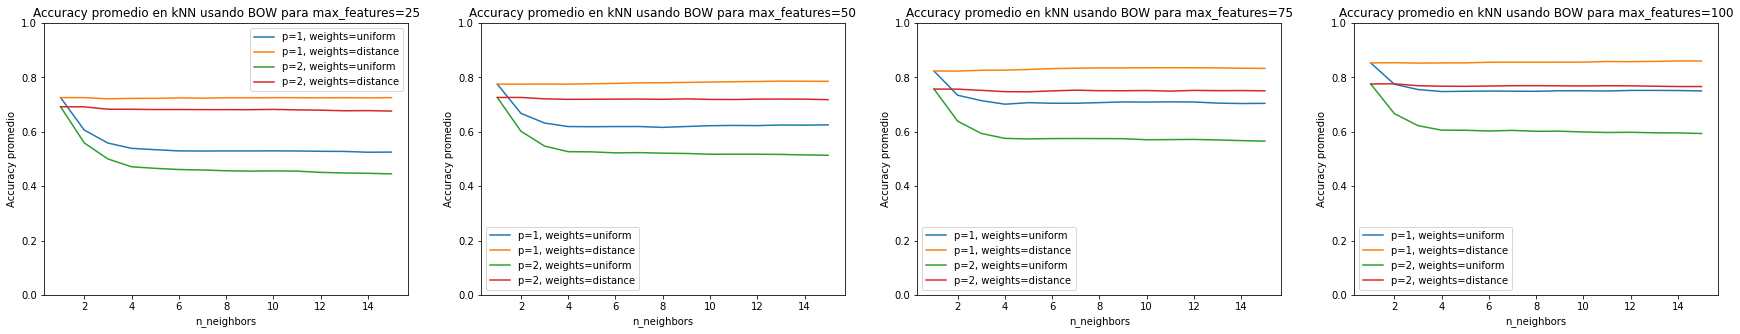

In [203]:
plot(knn_gscv_bow_maxf, "kNN", maxf_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "", "BOW")

In [19]:
print_scores(knn_gscv_bow_maxf, "knn", maxf_list, "BOW", "", X_train_knn_bow_maxf, X_test_knn_bow_maxf, 
             Y_train_knn_bow_maxf, Y_test_knn_bow_maxf)

Métricas de knn usando BOW con los mejores parámetros: 
Para max_features=25: Accuracy = 0.7773, Precision = 0.7817, Recall = 0.7807
Para max_features=50: Accuracy = 0.8293, Precision = 0.8386, Recall = 0.832
Para max_features=75: Accuracy = 0.8683, Precision = 0.8731, Recall = 0.8711
Para max_features=100: Accuracy = 0.8899, Precision = 0.895, Recall = 0.8932


Resulta poco sorprendente que las tres métricas tengan valores tan cercanos dado lo balanceado que está el dataset.

Ahora se tarbaja con el *TfidfVectorizer* (*TFIDF*) usando un top de features:

In [20]:
maxf_list = [25,50,75,100]
knn_gscv_tfidf_maxf = [None] * len(maxf_list)
X_train_knn_tfidf_maxf = [None] * len(maxf_list)
X_test_knn_tfidf_maxf = [None] * len(maxf_list)
Y_train_knn_tfidf_maxf = [None] * len(maxf_list)
Y_test_knn_tfidf_maxf = [None] * len(maxf_list)

for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (knn_gscv_tfidf_maxf[i], X_train_knn_tfidf_maxf[i], X_test_knn_tfidf_maxf[i], 
     Y_train_knn_tfidf_maxf[i], Y_test_knn_tfidf_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                            kwargs, "", 0, "knn", param_grid_knn, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


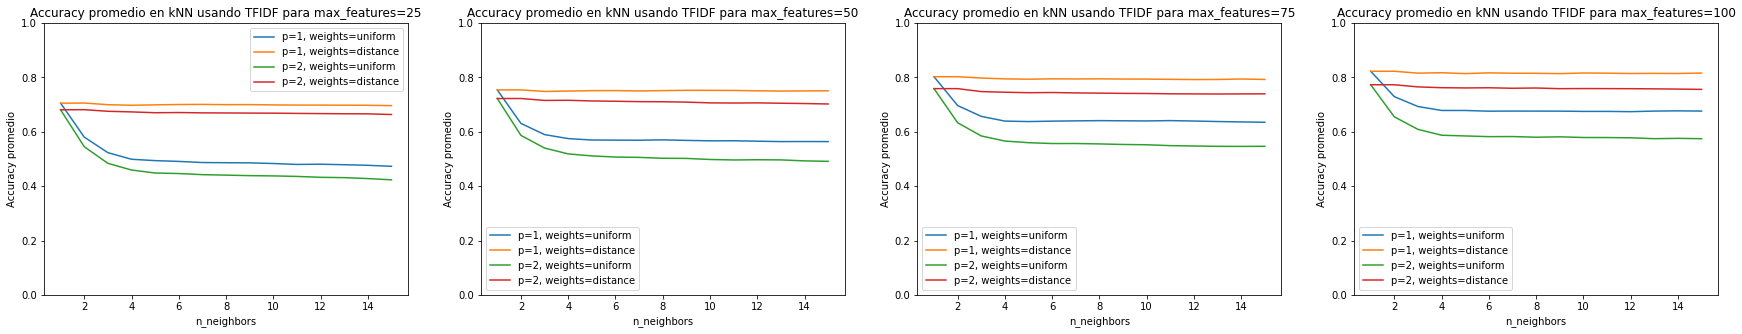

In [204]:
plot(knn_gscv_tfidf_maxf, "kNN", maxf_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "", "TFIDF")

In [22]:
print_scores(knn_gscv_tfidf_maxf, "knn", maxf_list, "TFIDF", "", X_train_knn_tfidf_maxf, X_test_knn_tfidf_maxf, 
             Y_train_knn_tfidf_maxf, Y_test_knn_tfidf_maxf)

Métricas de knn usando TFIDF con los mejores parámetros: 
Para max_features=25: Accuracy = 0.7576, Precision = 0.7613, Recall = 0.7612
Para max_features=50: Accuracy = 0.7949, Precision = 0.8028, Recall = 0.7977
Para max_features=75: Accuracy = 0.8296, Precision = 0.8366, Recall = 0.8337
Para max_features=100: Accuracy = 0.8496, Precision = 0.8545, Recall = 0.8544


In [23]:
for i in range(len(maxf_list)):
    print(knn_gscv_tfidf_maxf[i].best_params_)

{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


Se prueba usando *CountVectorizer* con *PCA*: 

In [24]:
maxv_list = [0.6, 0.7, 0.8, 0.9]
knn_gscv_bow_pca = [None] * len(maxv_list)
X_train_knn_bow_pca = [None] * len(maxv_list)
X_test_knn_bow_pca = [None] * len(maxv_list)
Y_train_knn_bow_pca = [None] * len(maxv_list)
Y_test_knn_bow_pca = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con PCA.
    (knn_gscv_bow_pca[i], X_train_knn_bow_pca[i], X_test_knn_bow_pca[i], 
     Y_train_knn_bow_pca[i], Y_test_knn_bow_pca[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", kwargs, 
                                                         "pca", maxv_list[i], "knn", param_grid_knn, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


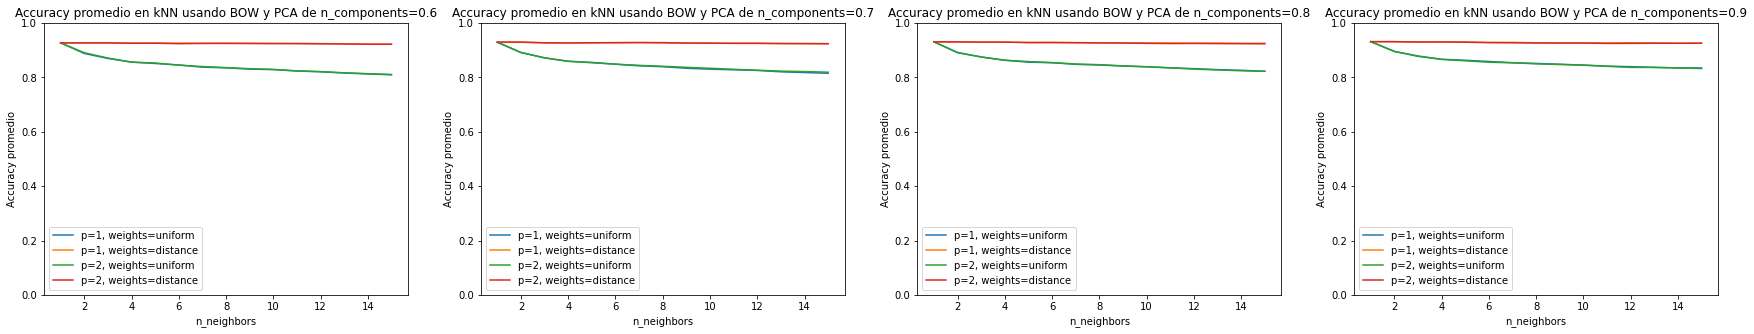

In [205]:
plot(knn_gscv_bow_pca, "kNN", maxv_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "pca", "BOW")

In [26]:
print_scores(knn_gscv_bow_pca, "knn", maxv_list, "BOW", "pca", X_train_knn_bow_pca, X_test_knn_bow_pca, 
             Y_train_knn_bow_pca, Y_test_knn_bow_pca)

Métricas de knn usando BOW con los mejores parámetros: 
Para PCA de n_components=0.6: Accuracy = 0.9461, Precision = 0.9481, Recall = 0.9473
Para PCA de n_components=0.7: Accuracy = 0.9429, Precision = 0.9442, Recall = 0.944
Para PCA de n_components=0.8: Accuracy = 0.944, Precision = 0.946, Recall = 0.945
Para PCA de n_components=0.9: Accuracy = 0.9461, Precision = 0.9478, Recall = 0.9476


Se prueba usando *TfidfVectorizer* con *PCA*:

In [27]:
maxv_list = [0.6, 0.7, 0.8, 0.9]
knn_gscv_tfidf_pca = [None] * len(maxv_list)
X_train_knn_tfidf_pca = [None] * len(maxv_list)
X_test_knn_tfidf_pca = [None] * len(maxv_list)
Y_train_knn_tfidf_pca = [None] * len(maxv_list)
Y_test_knn_tfidf_pca = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con PCA.
    (knn_gscv_tfidf_pca[i], X_train_knn_tfidf_pca[i], X_test_knn_tfidf_pca[i], 
     Y_train_knn_tfidf_pca[i], Y_test_knn_tfidf_pca[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                             kwargs, "pca", maxv_list[i], "knn", param_grid_knn, 
                                                             params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


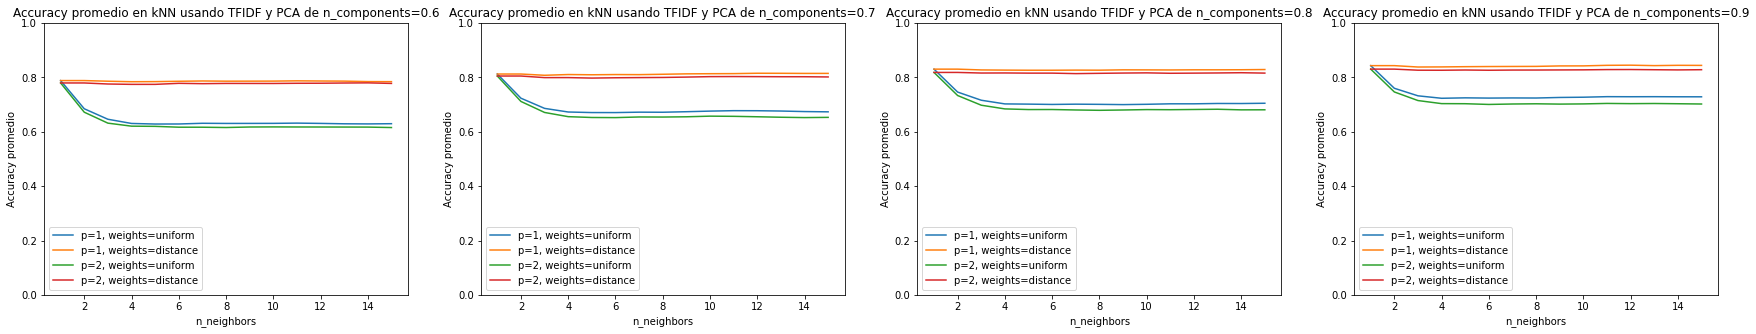

In [206]:
plot(knn_gscv_tfidf_pca, "kNN", maxv_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "pca", "TFIDF")

In [29]:
print_scores(knn_gscv_bow_pca, "knn", maxv_list, "TFIDF", "pca", X_train_knn_tfidf_pca, X_test_knn_tfidf_pca, 
             Y_train_knn_tfidf_pca, Y_test_knn_tfidf_pca)

Métricas de knn usando TFIDF con los mejores parámetros: 
Para PCA de n_components=0.6: Accuracy = 0.8304, Precision = 0.8357, Recall = 0.8358
Para PCA de n_components=0.7: Accuracy = 0.8504, Precision = 0.8563, Recall = 0.8559
Para PCA de n_components=0.8: Accuracy = 0.8651, Precision = 0.8715, Recall = 0.8696
Para PCA de n_components=0.9: Accuracy = 0.8741, Precision = 0.8789, Recall = 0.8784


Se prueba usando *CountVectorizer* con *SVD*:

In [30]:
maxfsvd_list = [25, 50, 75, 100]
knn_gscv_bow_svd = [None] * len(maxv_list)
X_train_knn_bow_svd = [None] * len(maxv_list)
X_test_knn_bow_svd = [None] * len(maxv_list)
Y_train_knn_bow_svd = [None] * len(maxv_list)
Y_test_knn_bow_svd = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con svd.
    (knn_gscv_bow_svd[i], X_train_knn_bow_svd[i], X_test_knn_bow_svd[i], 
     Y_train_knn_bow_svd[i], Y_test_knn_bow_svd[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", kwargs, 
                                                         "svd", maxfsvd_list[i], "knn", param_grid_knn, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


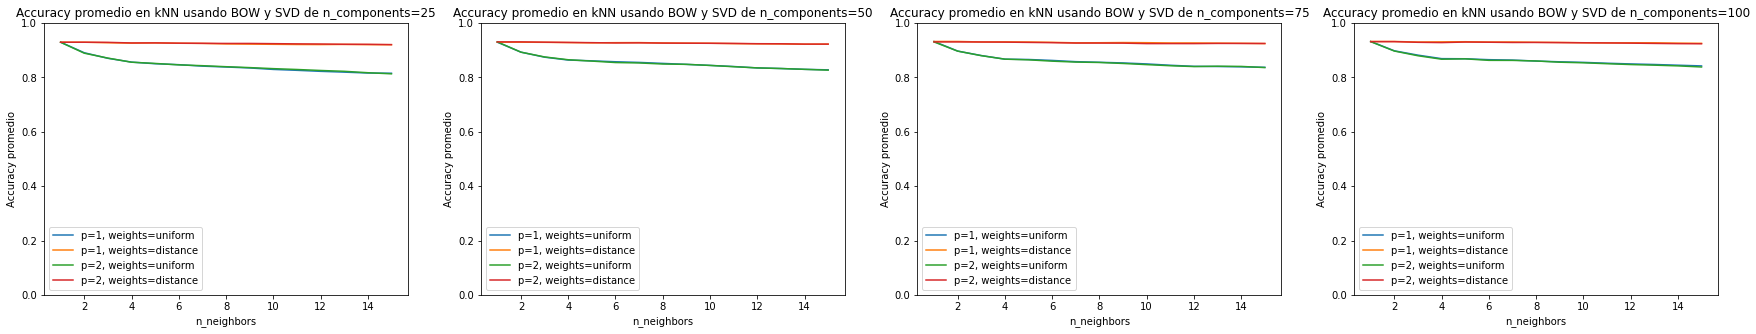

In [207]:
plot(knn_gscv_bow_svd, "kNN", maxfsvd_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "svd", "BOW")

In [32]:
print_scores(knn_gscv_bow_svd, "knn", maxfsvd_list, "BOW", "svd", X_train_knn_bow_svd, X_test_knn_bow_svd, 
             Y_train_knn_bow_svd, Y_test_knn_bow_svd)

Métricas de knn usando BOW con los mejores parámetros: 
Para SVD de n_components=25: Accuracy = 0.9379, Precision = 0.9399, Recall = 0.9394
Para SVD de n_components=50: Accuracy = 0.9435, Precision = 0.9442, Recall = 0.9447
Para SVD de n_components=75: Accuracy = 0.9459, Precision = 0.9476, Recall = 0.9472
Para SVD de n_components=100: Accuracy = 0.9448, Precision = 0.9469, Recall = 0.9466


Se prueba usando *TfidfVectorizer* con *SVD*:

In [33]:
maxfsvd_list = [25, 50, 75, 100]
knn_gscv_tfidf_svd = [None] * len(maxv_list)
X_train_knn_tfidf_svd = [None] * len(maxv_list)
X_test_knn_tfidf_svd = [None] * len(maxv_list)
Y_train_knn_tfidf_svd = [None] * len(maxv_list)
Y_test_knn_tfidf_svd = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con svd.
    (knn_gscv_tfidf_svd[i], X_train_knn_tfidf_svd[i], X_test_knn_tfidf_svd[i], 
     Y_train_knn_tfidf_svd[i], Y_test_knn_tfidf_svd[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                             kwargs, "svd", maxfsvd_list[i], "knn", param_grid_knn, 
                                                             params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


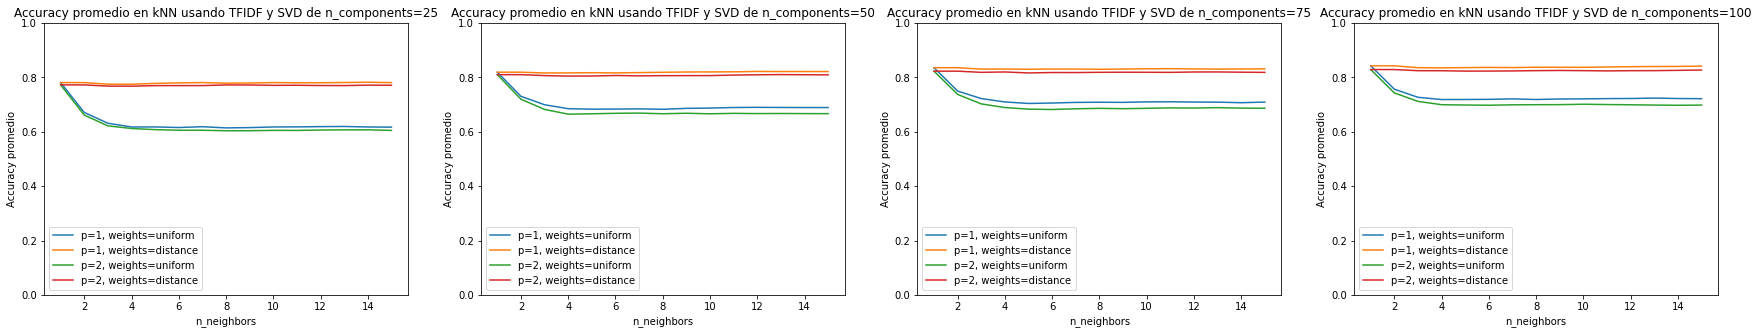

In [208]:
plot(knn_gscv_tfidf_svd, "kNN", maxfsvd_list, param_grid_knn, ["p", "weights"], "n_neighbors", 4, "svd", "TFIDF")

In [35]:
print_scores(knn_gscv_tfidf_svd, "knn", maxfsvd_list, "TFIDF", "svd", X_train_knn_tfidf_svd, X_test_knn_tfidf_svd, 
             Y_train_knn_tfidf_svd, Y_test_knn_tfidf_svd)

Métricas de knn usando TFIDF con los mejores parámetros: 
Para SVD de n_components=25: Accuracy = 0.816, Precision = 0.8249, Recall = 0.8216
Para SVD de n_components=50: Accuracy = 0.8581, Precision = 0.8662, Recall = 0.8627
Para SVD de n_components=75: Accuracy = 0.8667, Precision = 0.8716, Recall = 0.8715
Para SVD de n_components=100: Accuracy = 0.8725, Precision = 0.8763, Recall = 0.8769


Se muestra en un bar plot los puntajes en las tres métricas para cada una de las combinaciones *vectorizador* (BOW o TFIDF) + *método de reducción de dimensión* (top k featurees, PCA o SVD) + *clasificador* (kNN) con los mejores parámetros:

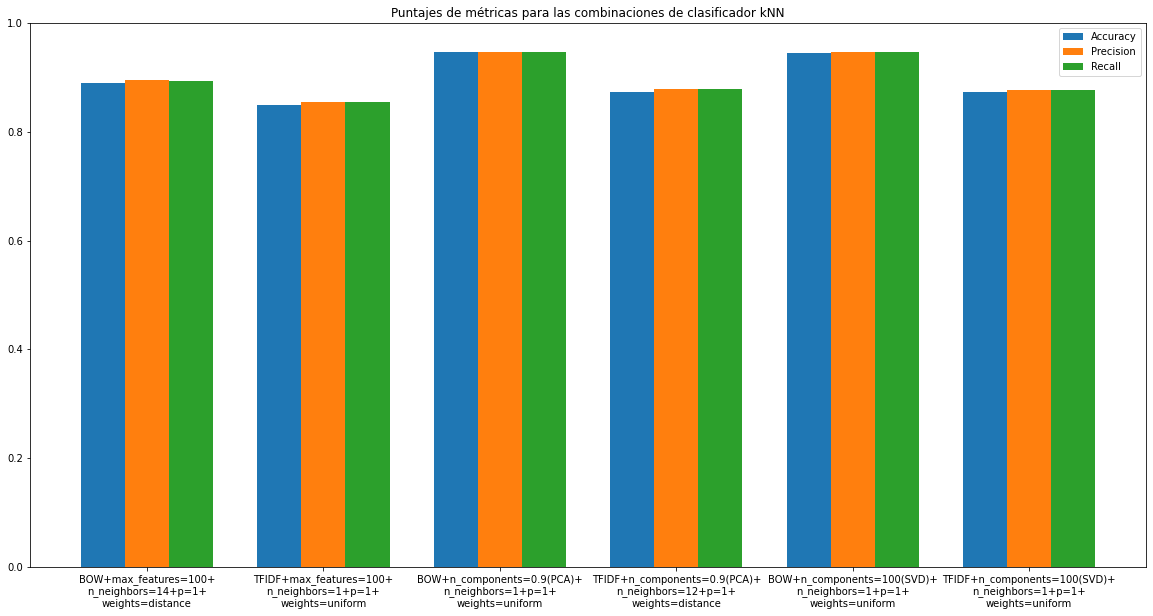

In [132]:
fig, ax = plt.subplots(figsize=(20,10))

(p_bow_f, wghts_bow_f, n_bow_f) = (knn_gscv_bow_maxf[3].best_params_["p"], 
                                   knn_gscv_bow_maxf[3].best_params_["weights"], 
                                   knn_gscv_bow_maxf[3].best_params_["n_neighbors"])
(p_tf_f, wghts_tf_f, n_tf_f) = (knn_gscv_tfidf_maxf[3].best_params_["p"], 
                                knn_gscv_tfidf_maxf[3].best_params_["weights"],
                                knn_gscv_tfidf_maxf[3].best_params_["n_neighbors"])
(p_bow_pca, wghts_bow_pca, n_bow_pca) = (knn_gscv_bow_pca[3].best_params_["p"], 
                                         knn_gscv_bow_pca[3].best_params_["weights"], 
                                         knn_gscv_bow_pca[3].best_params_["n_neighbors"])
(p_tf_pca, wghts_tf_pca, n_tf_pca) = (knn_gscv_tfidf_pca[3].best_params_["p"], 
                                      knn_gscv_tfidf_pca[3].best_params_["weights"], 
                                      knn_gscv_tfidf_pca[3].best_params_["n_neighbors"])
(p_bow_svd, wghts_bow_svd, n_bow_svd) = (knn_gscv_bow_svd[3].best_params_["p"], 
                                         knn_gscv_bow_svd[3].best_params_["weights"], 
                                         knn_gscv_bow_svd[3].best_params_["n_neighbors"])
(p_tf_svd, wghts_tf_svd, n_tf_svd) = (knn_gscv_tfidf_pca[3].best_params_["p"], 
                                      knn_gscv_tfidf_svd[3].best_params_["weights"], 
                                      knn_gscv_tfidf_svd[3].best_params_["n_neighbors"])
combs_knn = ['BOW+max_features=100+\nn_neighbors='+str(n_bow_f)+'+p='+str(p_bow_f)+'+\nweights='+str(wghts_bow_f) ,
             'TFIDF+max_features=100+\nn_neighbors='+str(n_tf_f)+'+p='+str(p_tf_f)+'+\nweights='+str(wghts_tf_f),
             'BOW+n_components=0.9(PCA)+\nn_neighbors='+str(n_bow_pca)+'+p='+str(p_bow_pca)+'+\nweights='+str(wghts_bow_pca),
             'TFIDF+n_components=0.9(PCA)+\nn_neighbors='+str(n_tf_pca)+'+p='+str(p_tf_pca)+'+\nweights='+str(wghts_tf_pca),
             'BOW+n_components=100(SVD)+\nn_neighbors='+str(n_bow_svd)+'+p='+str(p_bow_svd)+'+\nweights='+str(wghts_bow_svd),
             'TFIDF+n_components=100(SVD)+\nn_neighbors='+str(n_tf_svd)+'+p='+str(p_tf_svd)+'+\nweights='+str(wghts_tf_svd)]
accuracies_knn = [0.8899, 0.8496, 0.9461, 0.8741, 0.9448, 0.8725]
precisions_knn = [0.895, 0.8545, 0.9478, 0.8789, 0.9469, 0.8763]
recalls_knn = [0.8932, 0.8544, 0.9476, 0.8784, 0.9466, 0.8769]
x_axis = np.arange(len(combs_knn))

plt.bar(x_axis - 0.25, accuracies_knn, label = 'Accuracy', width=0.25)
plt.bar(x_axis + 0, precisions_knn, label = 'Precision', width=0.25)
plt.bar(x_axis + 0.25, recalls_knn, label = 'Recall', width = 0.25)

plt.xticks(x_axis, combs_knn)
plt.ylim([0,1])
plt.title("Puntajes de métricas para las combinaciones de clasificador kNN")
plt.legend(loc='upper right')
plt.show()

Resulta ser que la combinación con los mejores puntajes en las tres métricas para el clasificador kNN consiste en vectorizar con BOW, usando PCA con n_components=0.9, n_neighbors=1, p=1 y weights=uniform.

### Naive Bayes Multinomial

Ahora se prueba el clasificador **Naive Bayes Multinomial**, que es frecuentemente un buen método para problemas de clasificación de texto. Se aprovecha la cantidad baja de parámetros para probar con varios valores del parámetro principal $\alpha$ (*alpha*):

In [36]:
param_grid_mnb = {
    'alpha' : np.arange(0.1,2.1, 0.1),
    'fit_prior' : [False, True]
}

Se prueba *CountVectorizer* con un máximo de features (se trabaja con más features que para kNN porque MNB resultó ser más rápido pero menos potente para este problema):

In [37]:
maxf_list = [50,100,200,400]
mnb_gscv_bow_maxf = [None] * len(maxf_list)
X_train_mnb_bow_maxf = [None] * len(maxf_list)
X_test_mnb_bow_maxf = [None] * len(maxf_list)
Y_train_mnb_bow_maxf = [None] * len(maxf_list)
Y_test_mnb_bow_maxf = [None] * len(maxf_list)

for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (mnb_gscv_bow_maxf[i], X_train_mnb_bow_maxf[i], X_test_mnb_bow_maxf[i], 
     Y_train_mnb_bow_maxf[i], Y_test_mnb_bow_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", 
                                                           kwargs, "", 0, "mnb", param_grid_mnb, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


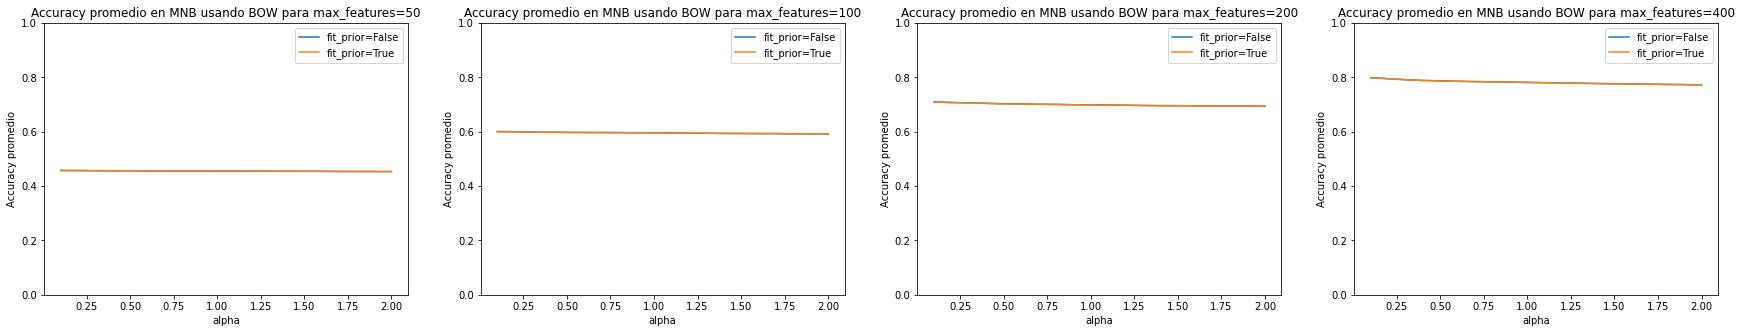

In [213]:
plot(mnb_gscv_bow_maxf, "MNB", maxf_list, param_grid_mnb, ["fit_prior"], "alpha", 4, "", "BOW")

In [39]:
print_scores(mnb_gscv_bow_maxf, "mnb", maxf_list, "BOW", "", X_train_mnb_bow_maxf, X_test_mnb_bow_maxf, 
             Y_train_mnb_bow_maxf, Y_test_mnb_bow_maxf)

Métricas de mnb usando BOW con los mejores parámetros: 
Para max_features=50: Accuracy = 0.4525, Precision = 0.4526, Recall = 0.4557
Para max_features=100: Accuracy = 0.6043, Precision = 0.6224, Recall = 0.6066
Para max_features=200: Accuracy = 0.7123, Precision = 0.7355, Recall = 0.7137
Para max_features=400: Accuracy = 0.8072, Precision = 0.8297, Recall = 0.809


Se prueba con *TfidfVectorizer* con un máximo de features:

In [40]:
maxf_list = [50,100,200,400]
mnb_gscv_tfidf_maxf = [None] * len(maxf_list)
X_train_mnb_tfidf_maxf = [None] * len(maxf_list)
X_test_mnb_tfidf_maxf = [None] * len(maxf_list)
Y_train_mnb_tfidf_maxf = [None] * len(maxf_list)
Y_test_mnb_tfidf_maxf = [None] * len(maxf_list)

for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (mnb_gscv_tfidf_maxf[i], X_train_mnb_tfidf_maxf[i], X_test_mnb_tfidf_maxf[i], 
     Y_train_mnb_tfidf_maxf[i], Y_test_mnb_tfidf_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                           kwargs, "", 0, "mnb", param_grid_mnb, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


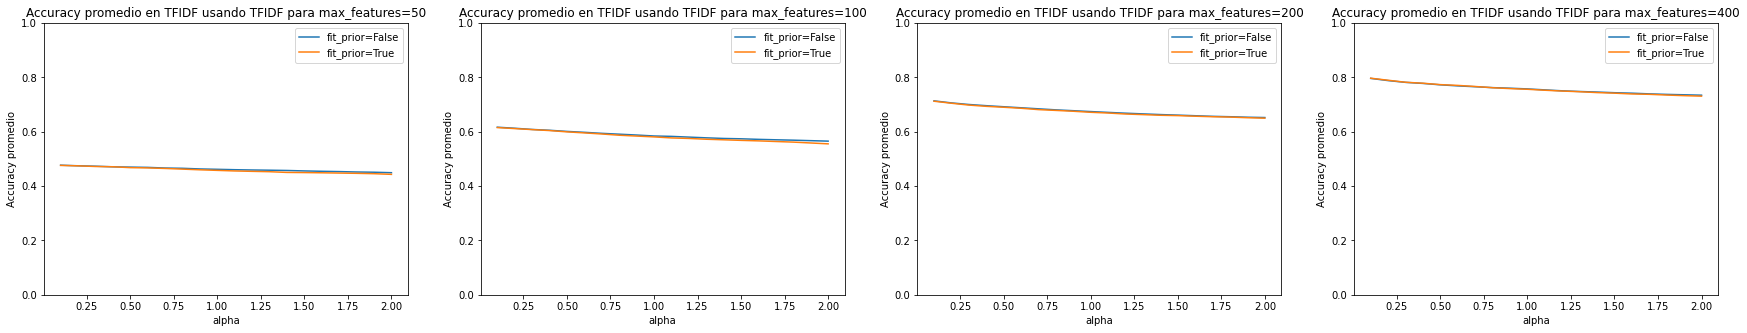

In [212]:
plot(mnb_gscv_tfidf_maxf, "TFIDF", maxf_list, param_grid_mnb, ["fit_prior"], "alpha", 4, "", "TFIDF")

In [42]:
print_scores(mnb_gscv_tfidf_maxf, "mnb", maxf_list, "TFIDF", "", X_train_mnb_bow_maxf, X_test_mnb_bow_maxf, 
             Y_train_mnb_bow_maxf, Y_test_mnb_bow_maxf)

Métricas de mnb usando TFIDF con los mejores parámetros: 
Para max_features=50: Accuracy = 0.4549, Precision = 0.456, Recall = 0.4578
Para max_features=100: Accuracy = 0.6043, Precision = 0.6224, Recall = 0.6066
Para max_features=200: Accuracy = 0.7123, Precision = 0.7355, Recall = 0.7137
Para max_features=400: Accuracy = 0.8067, Precision = 0.8291, Recall = 0.8084


**PCA y SVD no se aplican porque pueden generar valores negativos con los que MNB no es capaz de operar**.

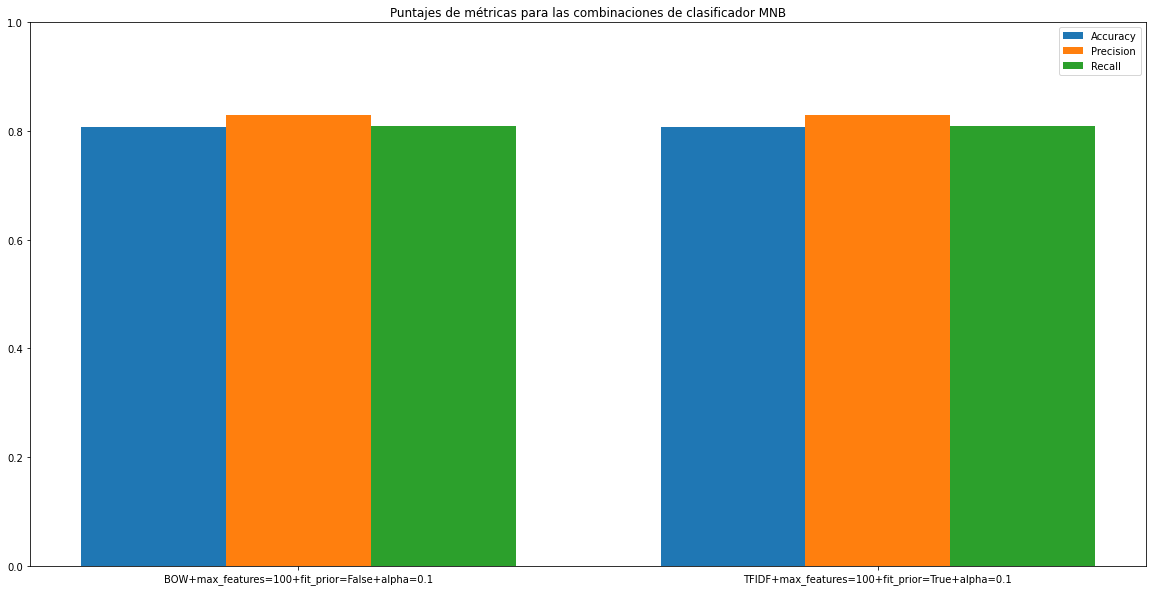

In [133]:
fig, ax = plt.subplots(figsize=(20,10))

fit_prior_bow_f, alpha_bow_f = mnb_gscv_bow_maxf[3].best_params_["fit_prior"], mnb_gscv_bow_maxf[3].best_params_["alpha"]
fit_prior_tf_f, alpha_tf_f = mnb_gscv_tfidf_maxf[3].best_params_["fit_prior"], mnb_gscv_tfidf_maxf[3].best_params_["alpha"]
combs_mnb = ['BOW+max_features=100+fit_prior='+str(fit_prior_bow_f)+"+alpha="+str(alpha_bow_f),
             'TFIDF+max_features=100+fit_prior='+str(fit_prior_tf_f)+"+alpha="+str(alpha_tf_f)]
accuracies_mnb = [0.8072, 0.8067]
precisions_mnb = [0.8297, 0.8291]
recalls_mnb = [0.809, 0.8084]
x_axis = np.arange(len(combs_mnb))

plt.bar(x_axis - 0.25, accuracies_mnb, label = 'Accuracy', width=0.25)
plt.bar(x_axis + 0, precisions_mnb, label = 'Precision', width=0.25)
plt.bar(x_axis + 0.25, recalls_mnb, label = 'Recall', width = 0.25)

plt.xticks(x_axis, combs_mnb)
plt.ylim([0,1])
plt.title("Puntajes de métricas para las combinaciones de clasificador MNB")
plt.legend(loc='upper right')
plt.show()

Resulta ser que la combinación con los mejores puntajes en las tres métricas para el clasificador SVC consiste en vectorizar con BOW, usando max_features=100, fit_prior=False y alpha=0.1.

### Support Vector Machines

Ahora se prueba el clasificador **SVC**, uno de los métodos más lentos.

In [43]:
param_grid_svc = {
    'C': np.arange(0.5, 3, 0.5),
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}

Se prueba *CountVectorizer* con un máximo de features:

In [71]:
maxf_list = [25,50,75,100]
svc_gscv_bow_maxf = [None] * len(maxf_list)
X_train_svc_bow_maxf = [None] * len(maxf_list)
X_test_svc_bow_maxf = [None] * len(maxf_list)
Y_train_svc_bow_maxf = [None] * len(maxf_list)
Y_test_svc_bow_maxf = [None] * len(maxf_list)

for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (svc_gscv_bow_maxf[i], X_train_svc_bow_maxf[i], X_test_svc_bow_maxf[i], 
     Y_train_svc_bow_maxf[i], Y_test_svc_bow_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", 
                                                           kwargs, "", 0, "svc", param_grid_svc, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


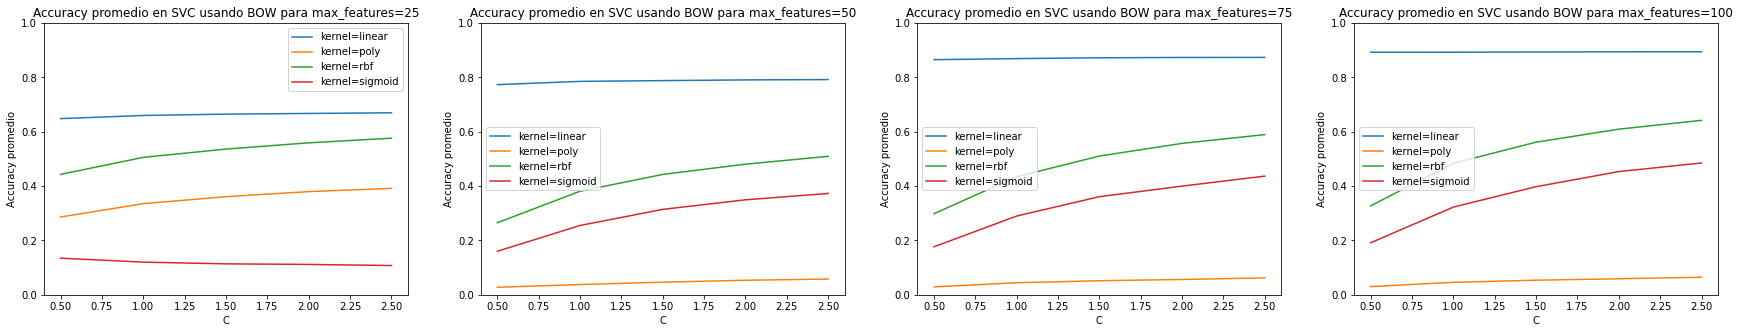

In [222]:
plot(svc_gscv_bow_maxf, "SVC", maxf_list, param_grid_svc, ["kernel"], "C", 4, "", "BOW")

In [72]:
print_scores(svc_gscv_bow_maxf, "svc", maxf_list, "BOW", "", X_train_svc_bow_maxf, X_test_svc_bow_maxf, 
             Y_train_svc_bow_maxf, Y_test_svc_bow_maxf)

Métricas de svc usando BOW con los mejores parámetros: 
Para max_features=25: Accuracy = 0.6744, Precision = 0.695, Recall = 0.6808
Para max_features=50: Accuracy = 0.8085, Precision = 0.8148, Recall = 0.8125
Para max_features=75: Accuracy = 0.8984, Precision = 0.901, Recall = 0.9012
Para max_features=100: Accuracy = 0.9163, Precision = 0.9191, Recall = 0.9186


In [102]:
with open("./svc_tfidf_maxf_data.db", "wb") as pickle_file:
    dill.dump(svc_gscv_bow_maxf, pickle_file)
    dill.dump(X_train_svc_bow_maxf, pickle_file)
    dill.dump(X_test_svc_bow_maxf, pickle_file)
    dill.dump(Y_train_svc_bow_maxf, pickle_file)
    dill.dump(Y_test_svc_bow_maxf, pickle_file)

Se prueba *TfidfVectorizer* con un máximo de features:

In [73]:
maxf_list = [25,50,75,100]
svc_gscv_tfidf_maxf = [None] * len(maxf_list)
X_train_svc_tfidf_maxf = [None] * len(maxf_list)
X_test_svc_tfidf_maxf = [None] * len(maxf_list)
Y_train_svc_tfidf_maxf = [None] * len(maxf_list)
Y_test_svc_tfidf_maxf = [None] * len(maxf_list)

for i in range(len(maxf_list)):
    kwargs['max_features'] = maxf_list[i]
    (svc_gscv_tfidf_maxf[i], X_train_svc_tfidf_maxf[i], X_test_svc_tfidf_maxf[i], 
     Y_train_svc_tfidf_maxf[i], Y_test_svc_tfidf_maxf[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                               kwargs, "", 0, "svc", param_grid_svc, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


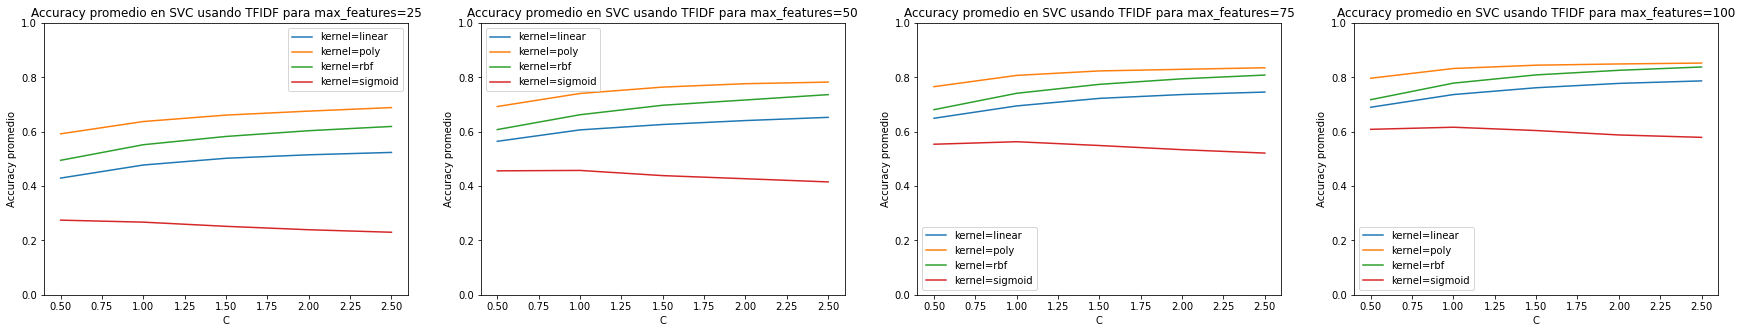

In [224]:
plot(svc_gscv_tfidf_maxf, "SVC", maxf_list, param_grid_svc, ["kernel"], "C", 4, "", "TFIDF")

In [95]:
print_scores(svc_gscv_tfidf_maxf, "svc", maxf_list, "TFIDF", "", X_train_svc_tfidf_maxf, X_test_svc_tfidf_maxf, 
             Y_train_svc_tfidf_maxf, Y_test_svc_tfidf_maxf)

Métricas de svc usando TFIDF con los mejores parámetros: 
Para max_features=25: Accuracy = 0.7141, Precision = 0.7278, Recall = 0.7173
Para max_features=50: Accuracy = 0.8061, Precision = 0.8116, Recall = 0.8099
Para max_features=75: Accuracy = 0.8584, Precision = 0.8628, Recall = 0.8631
Para max_features=100: Accuracy = 0.8736, Precision = 0.8789, Recall = 0.8776


In [108]:
with open("./svc_tfidf_maxf_data", "wb") as pickle_file:
    dill.dump(svc_gscv_tfidf_maxf, pickle_file)
    dill.dump(X_train_svc_tfidf_maxf, pickle_file)
    dill.dump(X_test_svc_tfidf_maxf, pickle_file)
    dill.dump(Y_train_svc_tfidf_maxf, pickle_file)
    dill.dump(Y_test_svc_tfidf_maxf, pickle_file)

Se prueba *CountVectorizer* con *PCA*:

In [74]:
maxv_list = [0.6, 0.7, 0.8, 0.9]
svc_gscv_bow_pca = [None] * len(maxv_list)
X_train_svc_bow_pca = [None] * len(maxv_list)
X_test_svc_bow_pca = [None] * len(maxv_list)
Y_train_svc_bow_pca = [None] * len(maxv_list)
Y_test_svc_bow_pca = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con PCA.
    (svc_gscv_bow_pca[i], X_train_svc_bow_pca[i], X_test_svc_bow_pca[i], 
     Y_train_svc_bow_pca[i], Y_test_svc_bow_pca[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", kwargs, 
                                                         "pca", maxv_list[i], "svc", param_grid_svc, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


In [110]:
with open("./svc_bow_pca_data.db", "wb") as pickle_file:
    dill.dump(svc_gscv_bow_pca, pickle_file)
    dill.dump(X_train_svc_bow_pca, pickle_file)
    dill.dump(X_test_svc_bow_pca, pickle_file)
    dill.dump(Y_train_svc_bow_pca, pickle_file)
    dill.dump(Y_test_svc_bow_pca, pickle_file)

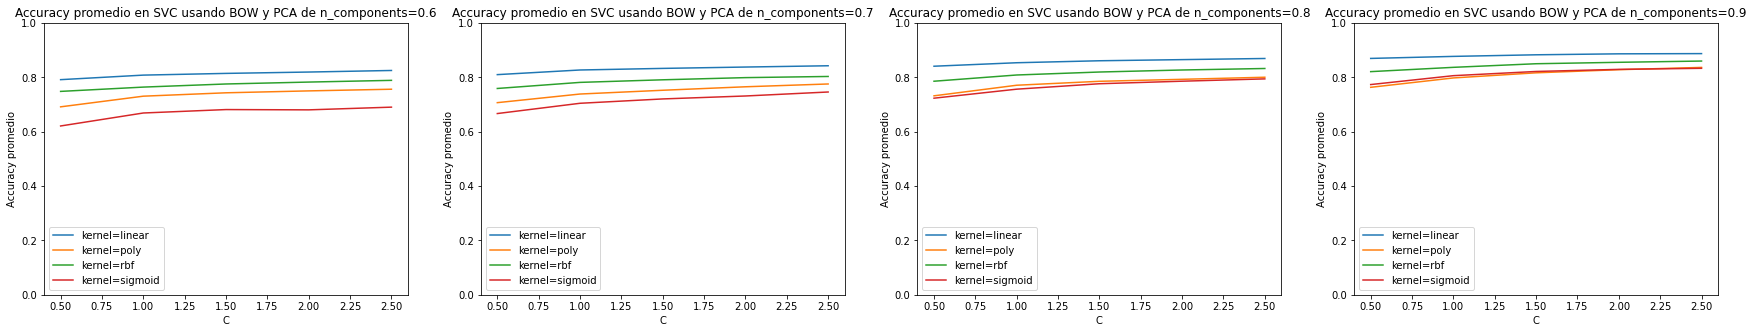

In [225]:
plot(svc_gscv_bow_pca, "SVC", maxv_list, param_grid_svc, ["kernel"], "C", 4, "pca", "BOW")

In [112]:
print_scores(svc_gscv_bow_pca, "SVC", maxv_list, "BOW", "pca", X_train_svc_bow_pca, X_test_svc_bow_pca, 
             Y_train_svc_bow_pca, Y_test_svc_bow_pca)

Métricas de svc usando BOW con los mejores parámetros: 
Para PCA de n_components=0.6: Accuracy = 0.8288, Precision = 0.8687, Recall = 0.831
Para PCA de n_components=0.7: Accuracy = 0.8461, Precision = 0.8805, Recall = 0.8481
Para PCA de n_components=0.8: Accuracy = 0.8672, Precision = 0.8945, Recall = 0.8691
Para PCA de n_components=0.9: Accuracy = 0.8821, Precision = 0.8979, Recall = 0.8847


Se prueba *TfidfVectorizer* con *PCA*:

In [ ]:
maxv_list = [0.6, 0.7, 0.8, 0.9]
svc_gscv_tfidf_pca = [None] * len(maxv_list)
X_train_svc_tfidf_pca = [None] * len(maxv_list)
X_test_svc_tfidf_pca = [None] * len(maxv_list)
Y_train_svc_tfidf_pca = [None] * len(maxv_list)
Y_test_svc_tfidf_pca = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con PCA.
    (svc_gscv_tfidf_pca[i], X_train_svc_tfidf_pca[i], X_test_svc_tfidf_pca[i], 
     Y_train_svc_tfidf_pca[i], Y_test_svc_tfidf_pca[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                             kwargs, "pca", maxv_list[i], "svc", param_grid_svc, 
                                                             params_cv)
    print("********** RUN " + str(i) + " DONE **********")

In [45]:
with open("./svc_tfidf_pca_data.db", "wb") as pickle_file:
    dill.dump(svc_gscv_tfidf_pca, pickle_file)
    dill.dump(X_train_svc_tfidf_pca, pickle_file)
    dill.dump(X_test_svc_tfidf_pca, pickle_file)
    dill.dump(Y_train_svc_tfidf_pca, pickle_file)
    dill.dump(Y_test_svc_tfidf_pca, pickle_file)

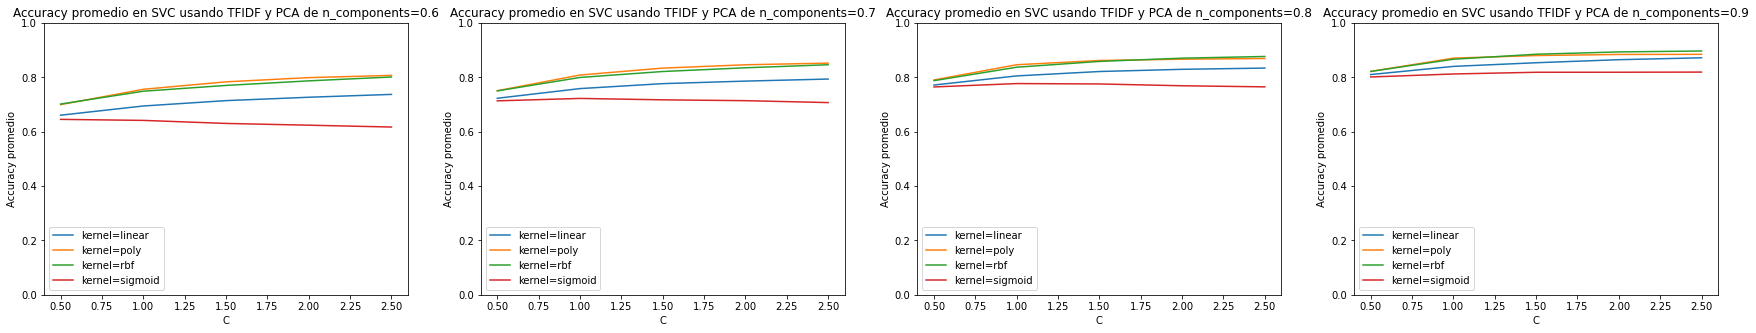

In [226]:
plot(svc_gscv_tfidf_pca, "SVC", maxv_list, param_grid_svc, ["kernel"], "C", 4, "pca", "TFIDF")

In [52]:
print_scores(svc_gscv_tfidf_pca, "svc", maxv_list, "TFIDF", "pca", X_train_svc_tfidf_pca, X_test_svc_tfidf_pca, 
             Y_train_svc_tfidf_pca, Y_test_svc_tfidf_pca)

Métricas de svc usando TFIDF con los mejores parámetros: 
Para PCA de n_components=0.6: Accuracy = 0.8317, Precision = 0.8476, Recall = 0.8355
Para PCA de n_components=0.7: Accuracy = 0.8693, Precision = 0.8773, Recall = 0.873
Para PCA de n_components=0.8: Accuracy = 0.8939, Precision = 0.9014, Recall = 0.897
Para PCA de n_components=0.9: Accuracy = 0.9091, Precision = 0.9164, Recall = 0.9122


Se prueba *CountVectorizer* con *SVD*:

In [46]:
maxfsvd_list = [25, 50, 75, 100]
svc_gscv_bow_svd = [None] * len(maxv_list)
X_train_svc_bow_svd = [None] * len(maxv_list)
X_test_svc_bow_svd = [None] * len(maxv_list)
Y_train_svc_bow_svd = [None] * len(maxv_list)
Y_test_svc_bow_svd = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con svd.
    (svc_gscv_bow_svd[i], X_train_svc_bow_svd[i], X_test_svc_bow_svd[i], 
     Y_train_svc_bow_svd[i], Y_test_svc_bow_svd[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "bow", kwargs, 
                                                         "svd", maxfsvd_list[i], "svc", param_grid_svc, params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


In [47]:
with open("./svc_bow_svd_data.db", "wb") as pickle_file:
    dill.dump(svc_gscv_bow_svd, pickle_file)
    dill.dump(X_train_svc_bow_svd, pickle_file)
    dill.dump(X_test_svc_bow_svd, pickle_file)
    dill.dump(Y_train_svc_bow_svd, pickle_file)
    dill.dump(Y_test_svc_bow_svd, pickle_file)

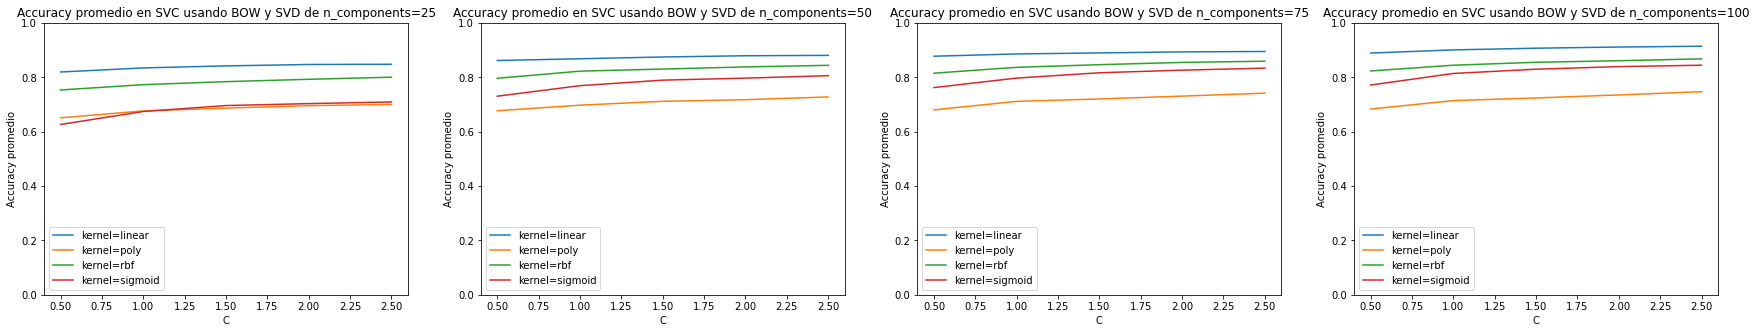

In [229]:
plot(svc_gscv_bow_svd, "SVC", maxfsvd_list, param_grid_svc, ["kernel"], "C", 4, "svd", "BOW")

In [58]:
print_scores(svc_gscv_bow_svd, "svc", maxfsvd_list, "BOW", "svd", X_train_svc_bow_svd, X_test_svc_bow_svd, 
             Y_train_svc_bow_svd, Y_test_svc_bow_svd)

Métricas de svc usando BOW con los mejores parámetros: 
Para SVD de n_components=25: Accuracy = 0.8563, Precision = 0.8896, Recall = 0.8581
Para SVD de n_components=50: Accuracy = 0.8779, Precision = 0.8937, Recall = 0.8802
Para SVD de n_components=75: Accuracy = 0.8912, Precision = 0.905, Recall = 0.8928
Para SVD de n_components=100: Accuracy = 0.9109, Precision = 0.9178, Recall = 0.9121


Se prueba *TfidfVectorizer* con *SVD*:

In [48]:
maxfsvd_list = [25, 50, 75, 100]
svc_gscv_tfidf_svd = [None] * len(maxv_list)
X_train_svc_tfidf_svd = [None] * len(maxv_list)
X_test_svc_tfidf_svd = [None] * len(maxv_list)
Y_train_svc_tfidf_svd = [None] * len(maxv_list)
Y_test_svc_tfidf_svd = [None] * len(maxv_list)

for i in range(len(maxv_list)):
    kwargs.pop("max_features", None) # Quito max_features, se reduce dimensión de vectores con svd.
    (svc_gscv_tfidf_svd[i], X_train_svc_tfidf_svd[i], X_test_svc_tfidf_svd[i], 
     Y_train_svc_tfidf_svd[i], Y_test_svc_tfidf_svd[i]) = CV(df_cpp_top_d, 0.75, "username", "flines", "tfidf", 
                                                             kwargs, "svd", maxfsvd_list[i], "svc", param_grid_svc, 
                                                             params_cv)
    print("********** RUN " + str(i) + " DONE **********")

********** RUN 0 DONE **********
********** RUN 1 DONE **********
********** RUN 2 DONE **********
********** RUN 3 DONE **********


In [49]:
with open("./svc_tfidf_svd_data.db", "wb") as pickle_file:
    dill.dump(svc_gscv_tfidf_svd, pickle_file)
    dill.dump(X_train_svc_tfidf_svd, pickle_file)
    dill.dump(X_test_svc_tfidf_svd, pickle_file)
    dill.dump(Y_train_svc_tfidf_svd, pickle_file)
    dill.dump(Y_test_svc_tfidf_svd, pickle_file)

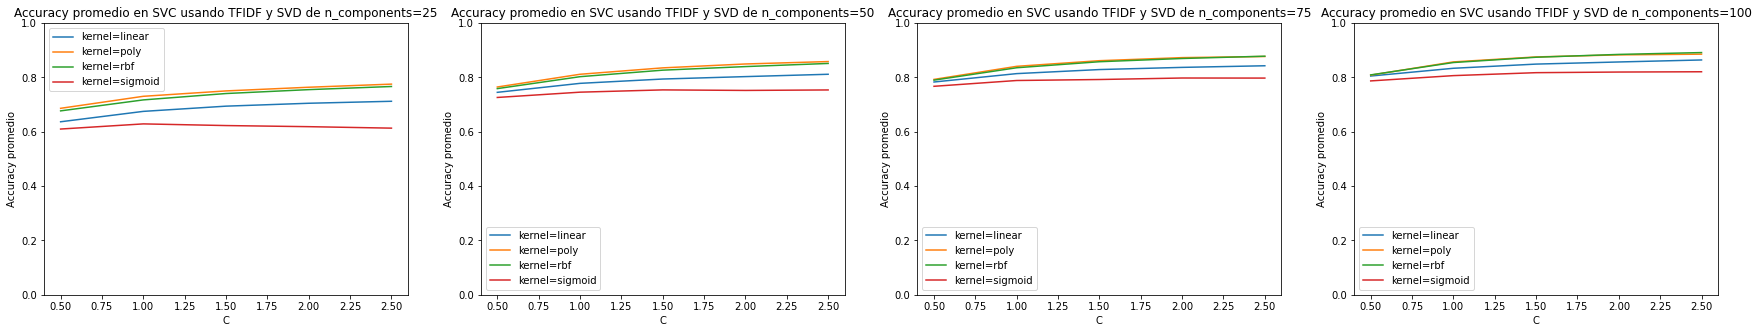

In [230]:
plot(svc_gscv_tfidf_svd, "SVC", maxfsvd_list, param_grid_svc, ["kernel"], "C", 4, "svd", "TFIDF")

In [59]:
print_scores(svc_gscv_tfidf_svd, "svc", maxfsvd_list, "TFIDF", "svd", X_train_svc_tfidf_svd, X_test_svc_tfidf_svd, 
             Y_train_svc_tfidf_svd, Y_test_svc_tfidf_svd)

Métricas de svc usando TFIDF con los mejores parámetros: 
Para SVD de n_components=25: Accuracy = 0.7851, Precision = 0.8055, Recall = 0.7885
Para SVD de n_components=50: Accuracy = 0.8683, Precision = 0.8785, Recall = 0.8717
Para SVD de n_components=75: Accuracy = 0.8925, Precision = 0.902, Recall = 0.8959
Para SVD de n_components=100: Accuracy = 0.9021, Precision = 0.9108, Recall = 0.9052


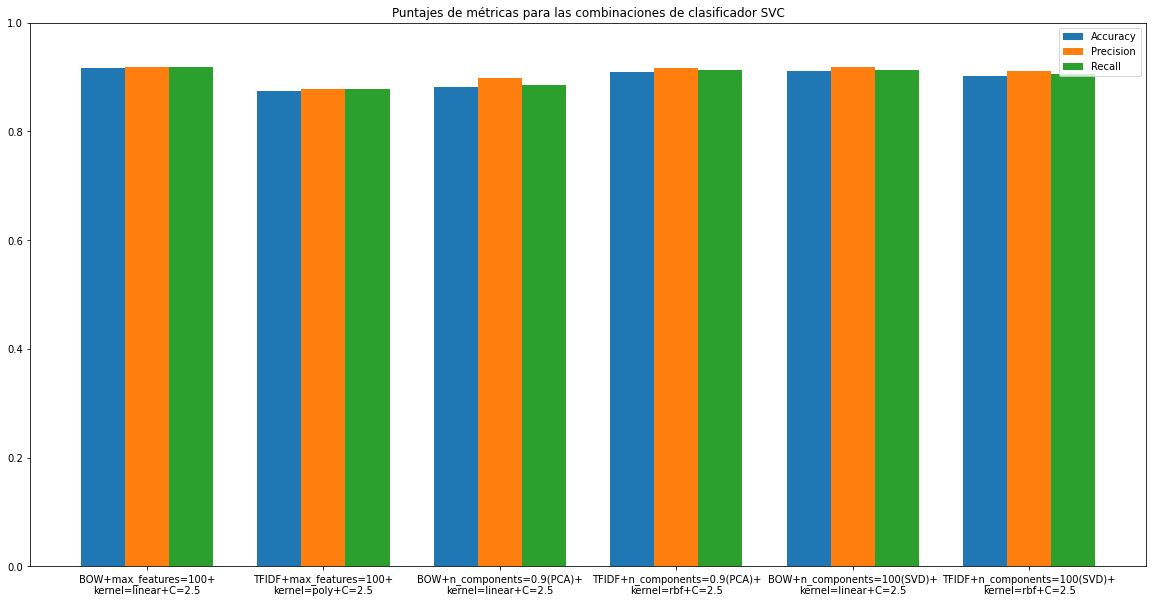

In [134]:
fig, ax = plt.subplots(figsize=(20,10))

kernel_bow_f, C_bow_f = svc_gscv_bow_maxf[3].best_params_["kernel"], svc_gscv_bow_maxf[3].best_params_["C"]
kernel_tf_f, C_tf_f = svc_gscv_tfidf_maxf[3].best_params_["kernel"], svc_gscv_tfidf_maxf[3].best_params_["C"]
kernel_bow_pca, C_bow_pca = svc_gscv_bow_pca[3].best_params_["kernel"], svc_gscv_bow_pca[3].best_params_["C"]
kernel_tf_pca, C_tf_pca = svc_gscv_tfidf_pca[3].best_params_["kernel"], svc_gscv_tfidf_pca[3].best_params_["C"]
kernel_bow_svd, C_bow_svd = svc_gscv_bow_svd[3].best_params_["kernel"], svc_gscv_bow_svd[3].best_params_["C"]
kernel_tf_svd, C_tf_svd = svc_gscv_tfidf_pca[3].best_params_["kernel"], svc_gscv_tfidf_pca[3].best_params_["C"]
combs_svc = ['BOW+max_features=100+\nkernel='+str(kernel_bow_f)+"+C="+str(C_bow_f),
             'TFIDF+max_features=100+\nkernel='+str(kernel_tf_f)+"+C="+str(C_tf_f),
             'BOW+n_components=0.9(PCA)+\nkernel='+str(kernel_bow_pca)+"+C="+str(C_bow_pca),
             'TFIDF+n_components=0.9(PCA)+\nkernel='+str(kernel_tf_pca)+"+C="+str(C_tf_pca),
             'BOW+n_components=100(SVD)+\nkernel='+str(kernel_bow_svd)+"+C="+str(C_bow_svd),
             'TFIDF+n_components=100(SVD)+\nkernel='+str(kernel_tf_svd)+"+C="+str(C_tf_svd)]
accuracies_svc = [0.9163, 0.8736, 0.8821, 0.9091, 0.9109, 0.9021]
precisions_svc = [0.9191, 0.8789, 0.8979, 0.9164, 0.9178, 0.9108]
recalls_svc = [0.9186, 0.8776, 0.8847, 0.9122, 0.9121, 0.9052]
x_axis = np.arange(len(combs_svc))

plt.bar(x_axis - 0.25, accuracies_svc, label = 'Accuracy', width=0.25)
plt.bar(x_axis + 0, precisions_svc, label = 'Precision', width=0.25)
plt.bar(x_axis + 0.25, recalls_svc, label = 'Recall', width = 0.25)

plt.xticks(x_axis, combs_svc)
plt.ylim([0,1])
plt.title("Puntajes de métricas para las combinaciones de clasificador SVC")
plt.legend(loc='upper right')
plt.show()

Resulta ser que la combinación con los mejores puntajes en las tres métricas para el clasificador SVC consiste en vectorizar con BOW, usando max_features=100, kernel=linear y C=2.5.

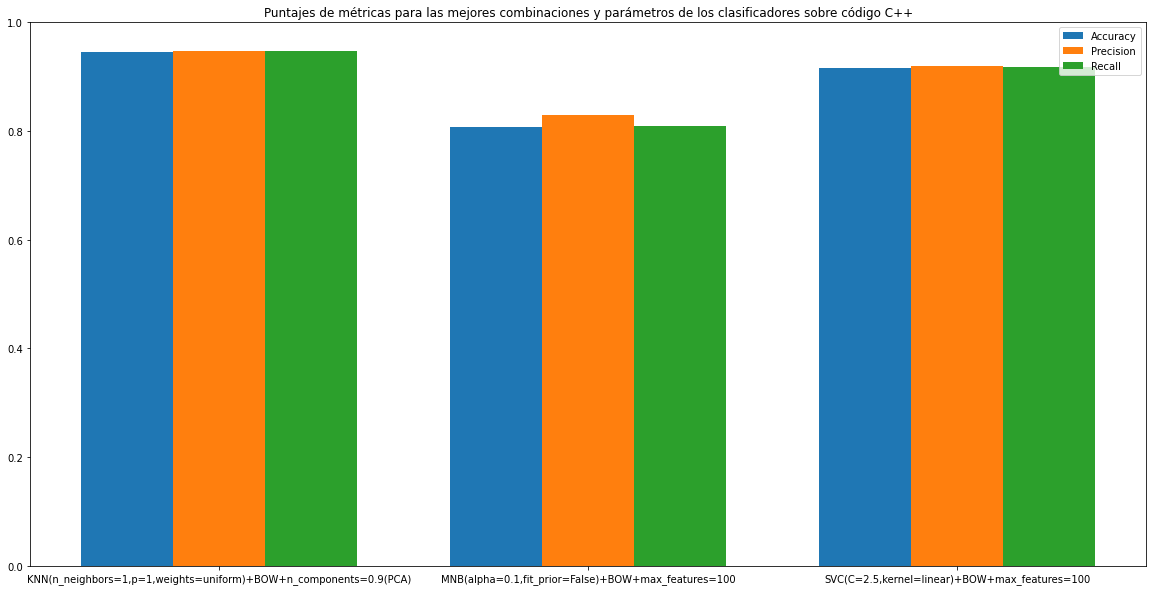

In [163]:
fig, ax = plt.subplots(figsize=(20,10))
combs_clf_cpp = ["KNN(n_neighbors=1,p=1,weights=uniform)+BOW+n_components=0.9(PCA)",
                 "MNB(alpha=0.1,fit_prior=False)+BOW+max_features=100",
                 "SVC(C=2.5,kernel=linear)+BOW+max_features=100"]
accuracies_cpp = [0.9461, 0.8072, 0.9163]
precisions_cpp = [0.9478, 0.8297, 0.9191]
recalls_cpp = [0.9476, 0.809, 0.9186]
x_axis = np.arange(len(combs_clf_cpp))

plt.bar(x_axis - 0.25, accuracies_cpp, label = 'Accuracy', width=0.25)
plt.bar(x_axis + 0, precisions_cpp, label = 'Precision', width=0.25)
plt.bar(x_axis + 0.25, recalls_cpp, label = 'Recall', width = 0.25)

plt.xticks(x_axis, combs_clf_cpp)
plt.ylim([0,1])
plt.title("Puntajes de métricas para las mejores combinaciones y parámetros de los clasificadores sobre código C++")
plt.legend(loc='upper right')
plt.show()

## Trabando con los códigos Python

Ahora que se conocen los mejores parámetros para los clasificadores testeados con código C++, es interesante preguntarse si tendrán una buena performance aplicados sobre código Python.

In [121]:
# Primero dejo en otro data frame las filas del data frame original 
# cuyos valores en la columna "file" terminan con "cpp" o "CPP":

df_py = df.copy(deep=True) # Copia profunda de df a df_py

# Dejo los últimos tres caracteres en la columna "file":
df_py["file"] = df_py["file"].str[-3:]
df_py = df_py[ df_py["file"] == ".py"]

df_py["username"].value_counts()

linguo           200
EricStansifer    176
RalfKistner      173
mth              161
kmod             149
                ... 
suneelius          1
Ichida             1
felipej            1
A.Ekeroot          1
ChihChiangWei      1
Name: username, Length: 21842, dtype: int64

In [122]:
# Se determinan los user_count usuarios con más contribuciones (py_top):
user_count = 100
usernames = df_py["username"].value_counts()
usernames.keys()[0:user_count]
py_top = [name for name in usernames.keys()[0:user_count]]

# Se extrae del dataset los user_count usuarios con más contribuciones
# y se los deja en py_top:
df_py_top = df_py.copy(deep=True)
# Se deja en el dataframe las filas correspondientes a usuarios en el top:
df_py_top = df_py_top[ df_py_top["username"].isin(py_top) ]
# Se borran las columnas innecesarias del dataframe:
df_py_top = df_py_top[["username","flines"]]
df_py_top

,username,flines
8,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \..."
464,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")..."
465,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
466,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
839,lidaobing,import sys\n \n def getints(ifile):\n retu...
...,...,...
1247336,bambit,import sys\n import math\n \n import heapq\n d...
1247337,bambit,import sys\n import math\n \n import heapq\n d...
1247338,bambit,"import sys\n \n def solve():\n N, K = map(..."
1248378,dvolgyes,#!/usr/bin/python3\n # -*- coding: utf-8 -*-\n...


In [123]:
df_py_top["username"].value_counts()#normalize=True)
#df_cpp_top["username"].value_counts().min()

linguo           200
EricStansifer    176
RalfKistner      173
mth              161
kmod             149
                ... 
yingted           75
grebnesieh        75
pawko             75
gilesg            75
sekiye            75
Name: username, Length: 100, dtype: int64

Nuevamente, las clases están desbalanceadas. Se balancean haciendo *downsampling* como con los códigos C++:

In [126]:
min_c = df_py_top["username"].value_counts().min()
df_py_top_d = downsample(df_py_top, "flines", "username", min_c)
df_py_top_d["username"].value_counts(normalize=True)

Nooodles      0.01
mth           0.01
liutianren    0.01
phire         0.01
killerrex     0.01
              ... 
Fizu          0.01
chaoticiak    0.01
nitsas        0.01
swiper        0.01
ymgve         0.01
Name: username, Length: 100, dtype: float64

Tras el *downsampling* quedan todos los usuarios con75 contribuciones (la mtad de lo que se tenía para el código C++). Luego, se tokeniza el código:

In [127]:
# Se reemplaza el código original por el tokenizado:
df_py_top_d["flines"] = tokenize(df_py_top_d["flines"], "py")
# Nota: Ignorar, de aparecer, el "SettingWithCopyWarning".

### K Nearest Neighbors

Se prueba con los mejores parámetros obtenidos al testear con el código C++ (vectorizando con BOW, usando PCA con n_components=0.9, n_neighbors=1, p=1 y weights=uniform):

In [148]:
param_grid_knn_py = {
    'n_neighbors' : [1],
    'weights' : ['uniform'],
    'p' : [1]
}

kwargs_knn_py = {
     'stop_words' : 'english',
    'max_df' : 0.9,
    'min_df' : 0.05,
    'ngram_range' : (1,3)
}

In [149]:
knn_gscv_py, X_train_knn_py, X_test_knn_py, Y_train_knn_py, Y_test_knn_py = CV(df_py_top_d, 0.75, "username", 
                                                                               "flines", "bow", kwargs_knn_py, "", 
                                                                               0.9, "knn", param_grid_knn_py, 
                                                                               params_cv)

In [150]:
print_scores([knn_gscv_py], "knn", [0.9], "BOW", "pca", [X_train_knn_py], [X_test_knn_py], [Y_train_knn_py], 
             [Y_test_knn_py])

Métricas de knn usando BOW con los mejores parámetros: 
Para PCA de n_components=0.9: Accuracy = 0.8027, Precision = 0.8126, Recall = 0.8064


## Naive Bayes Multinomial
Se prueba con los mejores parámetros obtenidos al testear con el código C++ (vectorizando con BOW, usando max_features=100, fit_prior=False y alpha=0.1):

In [153]:
param_grid_mnb_py = {
    'alpha' : [0.1],
    'fit_prior' : [False]
}

kwargs_mnb_py = {
    'stop_words' : 'english',
    'max_df' : 0.9,
    'min_df' : 0.05,
    'ngram_range' : (1,3),
    'max_features': 100
}

In [155]:
mnb_gscv_py, X_train_mnb_py, X_test_mnb_py, Y_train_mnb_py, Y_test_mnb_py = CV(df_py_top_d, 0.75, "username", 
                                                                               "flines", "bow", kwargs, "", 0, 
                                                                               "mnb", param_grid_mnb_py, params_cv)

In [156]:
print_scores([mnb_gscv_py], "mnb", [100], "BOW", "", [X_train_mnb_py], [X_test_mnb_py], [Y_train_mnb_py], 
             [Y_test_mnb_py])

Métricas de mnb usando BOW con los mejores parámetros: 
Para max_features=100: Accuracy = 0.5221, Precision = 0.5092, Recall = 0.519


## Support Vector Machines
Se prueba con los mejores parámetros obtenidos al testear con el código C++ (vectorizando con BOW, usando max_features=100, kernel=linear y C=2.5):

In [157]:
param_grid_svc_py = {
    'kernel' : ['linear'],
    'C' : [2.5]
}

kwargs_svc_py = {
    'stop_words' : 'english',
    'max_df' : 0.9,
    'min_df' : 0.05,
    'ngram_range' : (1,3),
    'max_features': 100
}

In [158]:
svc_gscv_py, X_train_svc_py, X_test_svc_py, Y_train_svc_py, Y_test_svc_py = CV(df_py_top_d, 0.75, "username", 
                                                                               "flines", "bow", kwargs_svc_py, "", 
                                                                               0, "svc", param_grid_svc_py, 
                                                                               params_cv)

In [159]:
print_scores([svc_gscv_py], "svc", [100], "BOW", "", [X_train_svc_py], [X_test_svc_py], [Y_train_svc_py], 
             [Y_test_svc_py])

Métricas de svc usando BOW con los mejores parámetros: 
Para max_features=100: Accuracy = 0.7957, Precision = 0.7974, Recall = 0.796


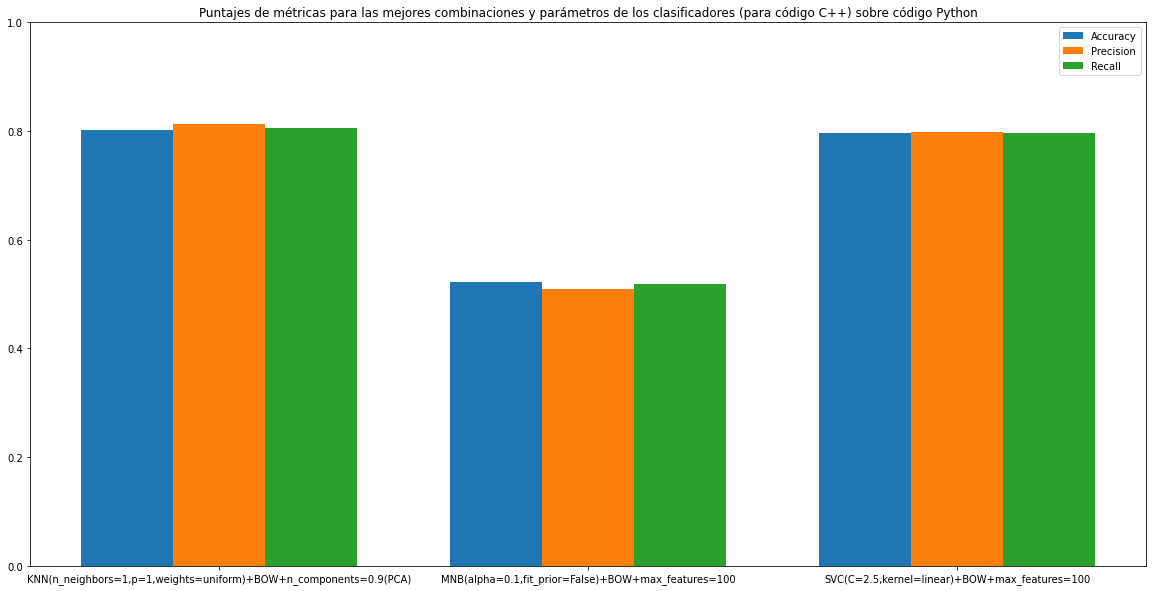

In [166]:
fig, ax = plt.subplots(figsize=(20,10))
combs_clf_py = ["KNN(n_neighbors=1,p=1,weights=uniform)+BOW+n_components=0.9(PCA)",
                "MNB(alpha=0.1,fit_prior=False)+BOW+max_features=100",
                "SVC(C=2.5,kernel=linear)+BOW+max_features=100"]
accuracies_py = [0.8027, 0.5221, 0.7957]
precisions_py = [0.8126, 0.5092, 0.7974]
recalls_py = [0.8064, 0.519, 0.796]
x_axis = np.arange(len(combs_clf_py))

plt.bar(x_axis - 0.25, accuracies_py, label = 'Accuracy', width=0.25)
plt.bar(x_axis + 0, precisions_py, label = 'Precision', width=0.25)
plt.bar(x_axis + 0.25, recalls_py, label = 'Recall', width = 0.25)

plt.xticks(x_axis, combs_clf_py)
plt.ylim([0,1])
plt.title("Puntajes de métricas para las mejores combinaciones y parámetros de los clasificadores (para código C++) sobre código Python")
plt.legend(loc='upper right')
plt.show()